<a href="https://colab.research.google.com/github/Jaewon45/BDAnalysis/blob/main/diabetes_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3-2. regression with DL
- example 1: diabetes
#### 1. Import data 

In [2]:
import numpy as np; import pandas as pd 
import seaborn as sns; import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets; mydata = datasets.load_diabetes()
df = pd.DataFrame(mydata['data'], columns = mydata['feature_names'])
df['diabetes_score'] = mydata['target']

- df.head(), df.describe().T시 데이터는 feature scaling이 완료된 상태이며, 모든 변수가 numeric이므로 원-핫/라벨인코딩 필요 X
- standardize를 통해 모든 X의 합 0, 성별도 수치형으로 코딩됨 
 - sex와 같은 범주형변수도 2class의 경우 수치형으로 코딩 괜찮, 3class 이상부터는 numeric으로 하면 안됨
- diabetes 점수가 높을수록 당뇨병 위험이 높음
#### 2. data preprocessing

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size = 0.2, 
                                                    shuffle = True, random_state = 22)

#### 3. building model
1. 은닉층 2개~추가 가능 : 일반적으로 상단방향으로 줄여나감 (절대적으로 좋은지는 모름)
 1. curve에서 loss 수렴해나가는 지점이 더 앞쪽
 2. (epoch)가 layer 수가 많아지면(모형이 복잡해지면) 수렴이 좀더 빨라진다고 볼 수 있음
 3. validation 선이 감소하고 있는지 확인해 early_stopping 고려
2. 중간에 batchnormalization module 추가 가능
 1. DNN, MLP보다 CNN에서 BN layer의 효과가 더 큼
 2. BN-layer 추가 후, Train과 validation의 loss와 mse의 변동량의 폭이 커지는 경향 (모듈추가로인한 노이즈)
 3. BN-layer 추가시 loss와 mse의 감소 속도가 느려지기 때문에 epoch를 증가시킬 필요가 있음
3. kernel_initializer = "he_normal"추가 가능 
 1. 성능이 가장 좋았던 Model의 입력층에 옵션 추가 => 파라미터 초기화 방법
 2. 결정계수가 증가해 성능이 소폭 증가했으나 이전 모형과 크게 달라지지 않음
 3. 수업에서 가장 좋은 성능을 보임
4. hidden layer 사이에 dropout 추가
 1. 모든 layer 사이에 Dropout을 넣지 않아도 괜찮음 (1,3,5 등 2, 3개만)
 2. rate은 CNN은 35~45%까지, RNN은 좀더 낮게
 3. 수업에서 dropout에 he_normal 추가 + dropout 일부 생략 + epoch증가시 성능향상 (아주소폭)
 4. 특이점 : loss, mse curve에서 validation에서 train보다 error가 감소할 수 있음

In [11]:
model = tf.keras.Sequential([
    # input layer
    # input_dim은 df.columns-1 (y 칼럼 제외하고 카운트)
    tf.keras.layers.Dense(128, activation = "relu", input_dim = (len(df.columns)-1),
                         kernel_initializer = "he_normal"), 
    tf.keras.layers.Dropout(0.2),

    # hidden layer : 활성화 relu
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16, activation = "relu"), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # output layer (dimension=1)
    tf.keras.layers.Dense(1, activation = "linear")])  # linear : identity F
    
# Convolution - Batch Normalization - Activation - Dropout - Pooling 순서

# model compile, summary
# optimizer for backpropatation (loss를 최소화하는 W 찾기위함)
model.compile(optimizer = "adam", loss = "mse", metrics = ['mse']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                      

#### 4. training model

In [5]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split = 0.2, verbose = 0)
# validation_split : 전체 훈련데이터중 loss 계산에 사용할만큼 남겨두기, parameter가 많기에 과적합방지
# verbose : 한바퀴 돌릴때 출력되는 option (0이면 없음, 1이면 process별, 2면 epoch별)
# verbose=1시 출력내용 : epoch별 loss, mse, validation의 loss와 mse

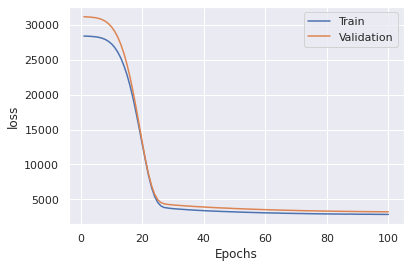

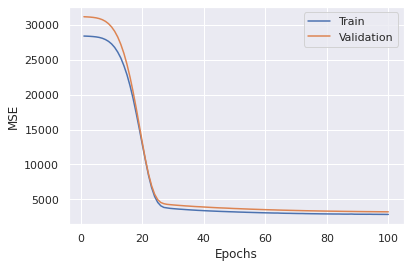

In [6]:
# loss function 시각화
def plot_loss_curve(total_epoch = 10, start = 1):
    import matplotlib.pyplot as plt; import seaborn as sns
    sns.set_theme(color_codes = True); plt.figure; plt.plot(figsize = (15,5))
    plt.plot(range(start, total_epoch +1), history.history['loss'][start-1:total_epoch], label = "Train")
    plt.plot(range(start, total_epoch +1), history.history['val_loss'][start-1:total_epoch], label = "Validation")
    plt.xlabel("Epochs"); plt.ylabel("loss"); plt.legend(); plt.show()
# mse function 시각화
def plot_mse_curve(total_epoch = 10, start = 1):
    plt.figure; plt.plot(figsize = (15,5)); 
    plt.plot(range(start, total_epoch +1), history.history['mse'][start-1:total_epoch], label = "Train")
    plt.plot(range(start, total_epoch +1), history.history['val_mse'][start-1:total_epoch], label = "Validation")
    plt.xlabel("Epochs"); plt.ylabel("MSE"); plt.legend(); plt.show()
plot_loss_curve(total_epoch=100, start = 1)
plot_mse_curve(total_epoch=100, start = 1)

- 40 이후로는 크게 줄지 않으니 total_epoch=40까지만 돌려도 괜찮음. 다시 진행해보기

#### 5) Test model

3/3 [==============================] - 0s 11ms/step - loss: 3310.1426 - mse: 3310.1428
테스트 세트의 MSE : 3310.1428


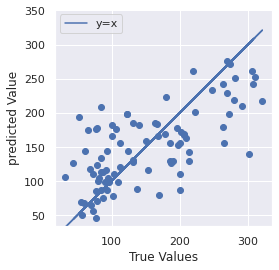

0.460068423463724

In [10]:
# 1. MSE
res = model.evaluate(X_test, y_test, verbose = 1)
print(f'테스트 세트의 MSE : {round(res[1], 4)}')
# 2. overserved vs fitted plot
plt.scatter(y_test, model.predict(X_test))
plt.xlabel("True Values"); plt.ylabel("predicted Value")
plt.axis("equal"); plt.axis("square")
plt.plot(y_test, y_test, label = "y=x"); plt.legend()
plt.show()
# 3. R_square
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

- 결정계수는 높지 않게 나올 것이지만 (회귀선과 관측치가 매우 가까워야함) 전반적으로 나쁘지 않음 
- 다른 challenging한 데이터들에 비해 퍼져있긴 해도 y=x 선 근처에 분포
- 전체 Y의 변동량중 47%정도를 회귀모형이 설명